<a href="https://colab.research.google.com/github/UBela/BV-ML-CV-Praktikum/blob/main/license_plate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from PIL import Image, ImageDraw
import torch
from torchvision import transforms
from create_dataset import Licenseplates
import pre_process_data

In [2]:
#create dataset
path_images = '../data/images/'
path_annotations = '../data/annotations/'
dataset = Licenseplates(path_images, path_annotations)

{'filename': 'Cars0.png', 'width': 500, 'height': 268, 'class': 0, 'bounding_box': [226, 125, 419, 173]}


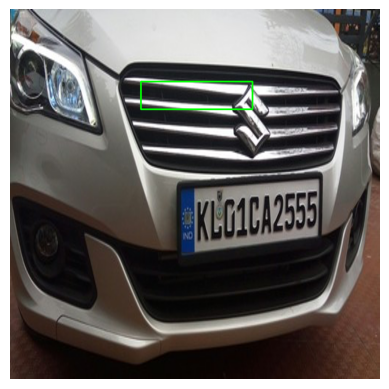

In [3]:
#example of image and bounding box
image, ann = dataset[0]
bb = ann['bounding_box']
print(ann)
image_array = np.array(image)
cv2.rectangle(image_array, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0), 2)
image_with_rectangle = Image.fromarray(image_array)
plt.imshow(image_with_rectangle)
plt.axis('off')
plt.show()

In [19]:
#pre-process images and annotations
pre_process_data.preprocess_images(path_images)


In [3]:
path = '../data/labels/' 
pre_process_data.preprocess_annotations(dataset.data, path)

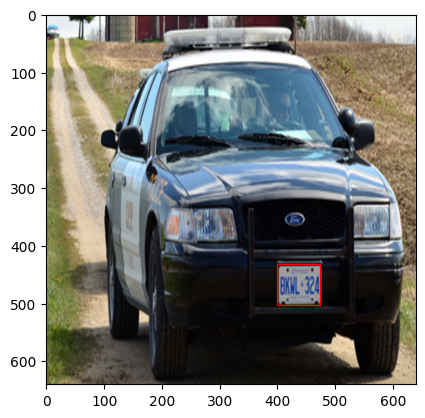

In [60]:
import random
import matplotlib.pyplot as plt

# Randomly select an image and its annotation and check if everything went well with the pre processing
index = random.randint(0, len(dataset) - 1)
image, annotation = dataset[index]

image_path = os.path.join(dataset.image_dir, annotation['filename'])
annotation_path = os.path.join('../data/labels/', annotation['filename'].replace('.png', '.txt'))

image = Image.open(image_path)

fig, ax = plt.subplots()

ax.imshow(image)

with open(annotation_path, 'r') as f:
    annotation_info = f.readline().strip().split(' ')
    annotation = [int(annotation_info[0])] + [float(value) for value in annotation_info[1:]]

class_id, x_center, y_center, bbox_width, bbox_height = annotation

image_width, image_height = image.size

xmin = int((x_center - bbox_width / 2) * image_width)
ymin = int((y_center - bbox_height / 2) * image_height)
bbox_width *= image_width
bbox_height *= image_height

rect = plt.Rectangle((xmin, ymin), bbox_width, bbox_height, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.show()


In [24]:
#split into train and test set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [25]:

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# get pretrained yolo model:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

/usr/local/lib/python3.9/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: Ultralytics requirement "gitpython>=3.1.30" not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 k